# Import

In [1]:
# System
import os
import json

# Data processing
import numpy as np
import math

# Plot
import matplotlib.pyplot as plt

# ML
    # pytorch
import torch 
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, StepLR
torch.set_num_threads(4) # Processor Setting
    # VAR
from statsmodels.tsa.api import VAR as var_model
from sklearn.preprocessing import MinMaxScaler
    # ESN
from scipy import linalg
import scipy
from sklearn.linear_model import Ridge

# Config

In [2]:
# Config path
root = '/Volumes/Expansion/User_Backup/b08209033/111-2_IVT_analysis/'
file = 'config.json'
config_path = os.path.join(root, file)

# Import config
with open(config_path) as infile:
    config = json.load(infile)
    infile.close()

# Update config
    # ML Parameters
        # DataLoader
config.update({"ML_hyperparam_lookback": 1})
config.update({"ML_hyperparam_batch_size": 32})
        # Epoch
config.update({"ML_hyperparam_nepochs": 100})
config.update({"ML_hyperparam_early_stop": 30})
config.update({"ML_hyperparam_forecast_step": 365})
        # optim
config.update({"ML_hyperparam_learning_rate": 5e-4})
config.update({"ML_hyperparam_weight_decay": 3e-6})
    # ML Fpath
config.update({"ML_path_model": os.path.join(config["Path_root"], "models")})
config.update({"ML_fname_model": "model.pt"})

# Export config
with open(config_path, 'w') as outfile:
    json.dump(config, outfile, sort_keys=True)
    outfile.close()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# DataLoader

In [4]:
def getDataLoader(train_set, valid_set, test_set, config):
    
    # Split, Train set
    train_len = config["ML_split_size"][0] - config["ML_hyperparam_lookback"]
    X_train = np.zeros((train_len, config["ML_hyperparam_lookback"], train_set.shape[-1]))
    Y_train = np.zeros((train_len,                                1, train_set.shape[-1]))
    for i in range(train_len):
        X_train[i,:,:] = train_set[i:i+config["ML_hyperparam_lookback"],:]
        Y_train[i,:,:] = train_set[i+config["ML_hyperparam_lookback"],:].reshape(1, -1)
    
    # Split, Valid set
    valid_len = config["ML_split_size"][1] - config["ML_hyperparam_lookback"]
    X_valid = np.zeros((valid_len, config["ML_hyperparam_lookback"], valid_set.shape[-1]))
    Y_valid = np.zeros((valid_len,                                1, valid_set.shape[-1]))
    for i in range(valid_len):
        X_valid[i,:,:] = valid_set[i:i+config["ML_hyperparam_lookback"],:]
        Y_valid[i,:,:] = valid_set[i+config["ML_hyperparam_lookback"],:].reshape(1, -1)
    
    # Split, Test set
    test_len = config["ML_split_size"][2] - config["ML_hyperparam_lookback"]
    X_test = np.zeros((test_len, config["ML_hyperparam_lookback"], test_set.shape[-1]))
    Y_test = np.zeros((test_len,                                1, test_set.shape[-1]))
    for i in range(test_len):
        X_test[i,:,:] = test_set[i:i+config["ML_hyperparam_lookback"],:]
        Y_test[i,:,:] = test_set[i+config["ML_hyperparam_lookback"],:].reshape(1, -1)
    # To Tensor
    X_train = torch.from_numpy(X_train)
    Y_train = torch.from_numpy(Y_train)
    X_valid = torch.from_numpy(X_valid)
    Y_valid = torch.from_numpy(Y_valid)
    X_test  = torch.from_numpy(X_test)
    Y_test  = torch.from_numpy(Y_test)
    # To Dataset
    train_data = TensorDataset(X_train, Y_train)
    valid_data = TensorDataset(X_valid, Y_valid)
    test_data  = TensorDataset(X_test,  Y_test)
    # To DataLoader
    train_loader = DataLoader(train_data, 
                              batch_size = config["ML_hyperparam_batch_size"],
                              shuffle = False,
                              pin_memory = True)
    valid_loader = DataLoader(valid_data, 
                              batch_size = config["ML_hyperparam_batch_size"],
                              shuffle = False,
                              pin_memory = True)
    test_loader  = DataLoader(test_data, 
                              batch_size = config["ML_hyperparam_batch_size"],
                              shuffle = False,
                              pin_memory = True)
    return train_loader, valid_loader, test_loader

In [5]:
# Read dataset
os.chdir(config["Path_IVT_calculation"])
with np.load(config["ML_fname_dataset"]) as dataset:
    train_set = dataset["train"]
    valid_set = dataset["valid"]
    test_set  = dataset["test"]
# To DataLoader
train_loader, valid_loader, test_loader = getDataLoader(train_set, valid_set, test_set, config)

# GRU

In [6]:
class GatedRecurrentUnit(object):
    def __init__(self, input_size, hidden_size, output_size, num_layers, device):
        self.device = device
        self.model = pytorch_GRU_FC(input_size  = input_size,
                                    hidden_size = hidden_size,
                                    output_size = output_size,
                                    num_layers  = num_layers).to(self.device).double()
        return None
    def trainer(self, train_loader, valid_loader, config):
        # Epoch
        n_epochs, step, early_stop_count = config['ML_hyperparam_nepochs'], 0, 0
        # Loss function
        best_loss = math.inf
        criterion = nn.MSELoss(reduction='mean').to(self.device)
        mean_train_loss_record = []
        mean_valid_loss_record = []
        # Optimizer
        optimizer = torch.optim.Adam(self.model.parameters(), 
                                     lr = config['ML_hyperparam_learning_rate'], 
                                     weight_decay = config['ML_hyperparam_weight_decay'])
        # Scheduler
        scheduler_CAWR = CosineAnnealingWarmRestarts(optimizer, 
                                                     T_0     = 50, 
                                                     T_mult  = 5, 
                                                     eta_min = config['ML_hyperparam_weight_decay']/1e4)
        # Training & Validating stage
        # In each epoch
            # Learn all train data one time
            # Learn all valid data one time
            # Evaluate learning progress
        for epoch in range(n_epochs):
            # Init
            self.model.train()
            loss_record = []
            
            for (x, y) in train_loader:
                optimizer.zero_grad() # Reset gradient
                x, y = x.to(self.device), y.to(self.device)
                pred = self.model(x)
                loss = criterion(pred[:,-1,:], y[:,-1,:]) # Calculate loss
                loss.backward() # Backward propagation
                optimizer.step() # Update model parameter
                step += 1
                loss_record.append(loss.detach().item())

            scheduler_CAWR.step()

            mean_train_loss_record.append(sum(loss_record)/len(loss_record))

            # Init
            self.model.eval() # VALIDATE
            loss_record = []
            
            for (x, y) in valid_loader:
                with torch.no_grad():
                    x, y = x.to(self.device), y.to(self.device)
                    pred = self.model(x)
                    loss = criterion(pred[:,-1,:], y[:,-1,:]) # Calculate loss
                # Detach loss
                loss_record.append(loss.item())

            # Valid loss
            mean_valid_loss_record.append(sum(loss_record)/len(loss_record))

            # Show progress
            if (epoch%10==0):
                print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss_record[-1]:.7f}, Valid loss: {mean_valid_loss_record[-1]:.7f}')

            # Save model parameter if better
            if mean_valid_loss_record[-1] < best_loss:
                best_loss = mean_valid_loss_record[-1]
                os.chdir(config["ML_path_model"])
                torch.save(self.model, config["ML_fname_model"])
                early_stop_count = 0
            else: 
                early_stop_count += 1

            # Early stop
            if early_stop_count >= config['ML_hyperparam_early_stop']:
                print('\nModel is not improving, so we halt the training session.')
                return mean_train_loss_record, mean_valid_loss_record

        return mean_train_loss_record, mean_valid_loss_record
    
    def tester(self, test_loader, config):
        os.chdir(config["ML_path_model"])
        best_model = torch.load(config["ML_fname_model"])
        predict = np.array([]).reshape(-1, )
        truth = np.array([]).reshape(-1, )
        for i, (x, y) in enumerate(test_loader):
            x = x.to(self.device)
            y = y.to(self.device)
            if (i==0):
                predict = np.reshape(predict, (-1, x.size()[-1]))
                truth = np.reshape(truth, (-1, x.size()[-1]))
            with torch.no_grad():
                pred = best_model(x)
                predict = np.concatenate((predict, pred.detach().cpu().numpy()[:,-1,:]), axis = 0)
                truth = np.concatenate((truth, y.detach().cpu().numpy()[:,-1,:]), axis = 0)
        return predict, truth
    def forecast(self, init, ntime):
        os.chdir(config["ML_path_model"])
        best_model = torch.load(config["ML_fname_model"])
        x = torch.from_numpy(init.reshape(1, config["ML_hyperparam_lookback"], -1)).to(self.device)
        preds = torch.reshape(torch.tensor([]), (0, x.size()[2]))
        with torch.no_grad():
            for i in range(ntime):
                pred = best_model(x)
                preds = torch.cat((preds, pred[:,-1,:]), 0)
                x = pred
        preds = preds.detach().numpy()
        return preds
class pytorch_GRU_FC(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(pytorch_GRU_FC, self).__init__()
        # Parameter
        self.input_length = input_size
        self.num_layers = num_layers
        self.hidden_dim = hidden_size
        # Structure
        self.GRU = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.FC = nn.Linear(hidden_size, output_size)
        # Weight init
        self.GRU.weight_ih_l0.data.fill_(0)
        self.GRU.weight_hh_l0.data.fill_(0)
        self.FC.weight.data.fill_(0)
    def forward(self, x):
        # Hidden init
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, dtype = torch.double).requires_grad_()
        # GRU pass
        out, (hn) = self.GRU(x, (h0.detach()))
        # FC pass
        out = self.FC(out[:, -1, :])
        # Output
        out = torch.reshape(out, (out.size()[0], 1, out.size()[-1]))
        return out

In [7]:
# Init
GRU = GatedRecurrentUnit(input_size = train_set.shape[-1], 
                         hidden_size = 160, 
                         output_size = train_set.shape[-1], 
                         num_layers = 1, 
                         device = device)
# Train
train_loss_record, valid_loss_record = GRU.trainer(train_loader, valid_loader, config)
# Test
GRU_predict, GRU_truth = GRU.tester(test_loader, config)
# Forecast
GRU_IC = test_set[0:config["ML_hyperparam_lookback"],:]
GRU_forecast = GRU.forecast(GRU_IC, config["ML_hyperparam_forecast_step"])

Epoch [1/100]: Train loss: 0.0385942, Valid loss: 0.0754712
Epoch [11/100]: Train loss: 0.0146069, Valid loss: 0.0283042
Epoch [21/100]: Train loss: 0.0143628, Valid loss: 0.0276748
Epoch [31/100]: Train loss: 0.0141322, Valid loss: 0.0272753
Epoch [41/100]: Train loss: 0.0139760, Valid loss: 0.0270524
Epoch [51/100]: Train loss: 0.0141376, Valid loss: 0.0270401
Epoch [61/100]: Train loss: 0.0135764, Valid loss: 0.0260587
Epoch [71/100]: Train loss: 0.0130799, Valid loss: 0.0254680
Epoch [81/100]: Train loss: 0.0127139, Valid loss: 0.0251378
Epoch [91/100]: Train loss: 0.0124474, Valid loss: 0.0249535


# VAR

In [8]:
class VarAutoReg(object):
    def trainer(self, train, lags, trend):
        self.AR_p = lags
        self.trend = trend
        self.train_data = train
        self.VAR = var_model(self.train_data)
        self.VARResult = self.VAR.fit(maxlags = self.AR_p, trend = self.trend)
        return self.VARResult
    def tester(self, test, config):
        self.test_data = test
        predict = np.array([]).reshape(-1, self.test_data.shape[-1])
        truth = np.array([]).reshape(-1, self.test_data.shape[-1])
        for i in range(len(self.test_data)-config["ML_hyperparam_lookback"]):
            pred = self.VARResult.forecast(self.test_data[i:i+config["ML_hyperparam_lookback"]].reshape(config["ML_hyperparam_lookback"],-1), 1)
            predict = np.concatenate((predict, pred), axis = 0)
            truth = np.concatenate((truth, self.test_data[i+1,:].reshape(1,-1)), axis = 0)
        return predict, truth
    def forecast(self, init, ntime):
        pred = self.VARResult.forecast(init, ntime)
        return pred

In [9]:
# Init
VAR = VarAutoReg()
# Train
VAR.trainer(train_set, lags = config["ML_hyperparam_lookback"], trend = "n")
# Test
VAR_predict, VAR_truth = VAR.tester(test_set, config)
# Forecast
VAR_IC = test_set[0:config["ML_hyperparam_lookback"],:].reshape(config["ML_hyperparam_lookback"],-1)
VAR_forecast = VAR.forecast(VAR_IC, config["ML_hyperparam_forecast_step"])

# ESN

In [10]:
class Reservoir(object):
    def __init__(self, resSize = 500, spectral_radius = 1.25, leaky = 0.3, reg_coefficient = 1e-8, sparsity = 1.00, noise = 1e-2, feature_num = None):
        # Parameter
        self.resSize = resSize
        self.rho = spectral_radius
        self.alpha = leaky
        self.reg_coef = reg_coefficient
        self.sparse = sparsity
        self.noise_level = noise
        self.inSize = feature_num
        self.outSize = feature_num
        # Weight matrix
        np.random.seed(54088)
        self.Win = np.random.rand(self.resSize, 1+self.inSize)-0.5
        np.random.seed(54088)
        #self.W_0 = np.random.rand(self.resSize, self.resSize)-0.5
        self.W_0 = scipy.sparse.rand(self.resSize, self.resSize, density=self.sparse).todense()
        self.W_0[np.where(self.W_0 > 0)] = self.W_0[np.where(self.W_0 > 0)] - 0.5
        self.W_0 = np.asarray(self.W_0)
        self.rhoW = np.max(np.abs(np.linalg.eig(self.W_0)[0]))
        self.W = self.W_0 * self.rho / self.rhoW
        # Optim
        self.Ridge = None
        return None
    def Dataset(self, train, test):
        self.dataset = np.concatenate((train, test), axis = 0)
        self.trainLen = train.shape[0]
        self.testLen = test.shape[0]
        self.initLen = int(self.trainLen/10)
        return None
    def trainer(self):
        prev_state = []
        current_state = np.zeros([self.resSize, 1])
        for t in range(self.trainLen):
            obs = self.dataset[t,:]
            obs = np.reshape(obs, [self.inSize,1])
            # Update state
            current_state = (1-self.alpha)*current_state + self.alpha*np.tanh( np.dot(self.Win, np.vstack((1, obs))) + np.dot(self.W, current_state) + (np.random.rand(self.resSize, 1)-0.5)*self.noise_level)
            prev_state.append(np.vstack([1, obs, current_state]))
        # Discard spin-up
        prev_state = prev_state[self.initLen:]
        prev_state = np.array(prev_state).reshape(-1, 1+self.inSize+self.resSize)

        # Ground true state
        truth_state = self.dataset[self.initLen+1:self.trainLen+1,:]

        # Least Square Error (similar to loss function)
        self.Ridge = Ridge(alpha = self.reg_coef)
        self.Ridge.fit(prev_state, truth_state)
        return current_state
    def tester(self, current_state, config, ntime = None, Mode = 0):
        predict = np.array([]).reshape(-1, self.outSize)
        obs = self.dataset[self.trainLen,:]
        obs = np.reshape(obs, [self.inSize,1])
        unit = np.ones((1,1))
        
        for t in range(config["ML_hyperparam_lookback"]):
            current_state = (1-self.alpha)*current_state + self.alpha*np.tanh(np.dot(self.Win, np.vstack((unit, obs))) + np.dot(self.W, current_state))
            y = self.Ridge.predict(np.vstack((1, obs, current_state)).T)
            predict = np.concatenate((predict, y), axis = 0)
            obs = self.dataset[self.trainLen+t+1]
            obs = np.reshape(obs, [self.inSize,1])
            
        for t in range(config["ML_hyperparam_lookback"], self.testLen-1):
            current_state = (1-self.alpha)*current_state + self.alpha*np.tanh(np.dot(self.Win, np.vstack((unit, obs))) + np.dot(self.W, current_state))
            y = self.Ridge.predict(np.vstack((1, obs, current_state)).T)
            predict = np.concatenate((predict, y), axis = 0)
            if (Mode==0):
                # Iterative step
                obs = self.dataset[self.trainLen+t+1]
                obs = np.reshape(obs, [self.inSize,1])
            elif (Mode==1):
                obs = y
                obs = np.reshape(obs, [self.inSize,1])

        predict = np.array(predict).reshape(-1, self.outSize)[config["ML_hyperparam_lookback"]-1:]
        truth = self.dataset[self.trainLen+1:,:][config["ML_hyperparam_lookback"]-1:]
        
        if (Mode==0):
            return predict, truth
        elif (Mode==1):
            return predict[:ntime]
        

In [20]:
# Init
ESN = Reservoir(resSize = 1000,
                spectral_radius = 2,
                leaky = 0.3,
                reg_coefficient = 1e-8,
                sparsity = 0.05,
                noise = 1e-2,
                feature_num = config["Var_Feature_num_SVD"] + config["Flag_timeline_feature"])
# Dataset
ESN.Dataset(np.concatenate((train_set, valid_set), axis = 0), test_set)
# Train
post_train_state = ESN.trainer()
# Test
ESN_predict, ESN_truth = ESN.tester(post_train_state, config, Mode = 0)
# Forecast
ESN_IC = np.copy(post_train_state)
ESN_forecast= ESN.tester(ESN_IC, config, ntime = config["ML_hyperparam_forecast_step"], Mode = 1)

In [12]:
"""
arr = np.linspace(0,1,1)
for item in arr:  
    # Init
    ESN = Reservoir(resSize = 3000,
                    spectral_radius = 2,
                    leaky = 0.45,
                    reg_coefficient = 1,
                    sparsity = 0.05,
                    noise = 1,
                    feature_num = config["Var_Feature_num_SVD"] + config["Flag_timeline_feature"])
    # Dataset
    ESN.Dataset(np.concatenate((train_set, valid_set), axis = 0), test_set)
    # Train
    state_vect = ESN.trainer()
    # Test
    ESN_predict, ESN_truth = ESN.tester(state_vect, config, Mode = 1)
    MSE_ESN = np.mean(np.square(ESN_predict - ESN_truth))
    print(f"Item: {item:.3f}, MSE: {MSE_ESN:.5f}")
    fig, axes = plt.subplots(nrows = 6,
                             ncols = 6, 
                             figsize = (4*6, 3*6), 
                             dpi = 100,
                             constrained_layout = True)
    for i, ax in enumerate(axes.flat):
        ax.plot(ESN_predict[:time_window, i], zorder = 3)
        ax.plot(ESN_truth[:time_window, i])
        ax.set_title(f"Mode: {i}")
    plt.show()
"""
print("On progress")

On progress


# Compare

In [21]:
MSE_GRU = np.mean(np.square(GRU_predict - GRU_truth))
MSE_VAR = np.mean(np.square(VAR_predict - VAR_truth))
MSE_ESN = np.mean(np.square(ESN_predict - ESN_truth))
print("GRU: ", f"{MSE_GRU:.6f}")
print("VAR: ", f"{MSE_VAR:.6f}")
print("ESN: ", f"{MSE_ESN:.6f}")

GRU:  0.017685
VAR:  0.020262
ESN:  0.030663


In [22]:
mode = 0
time_window = -1

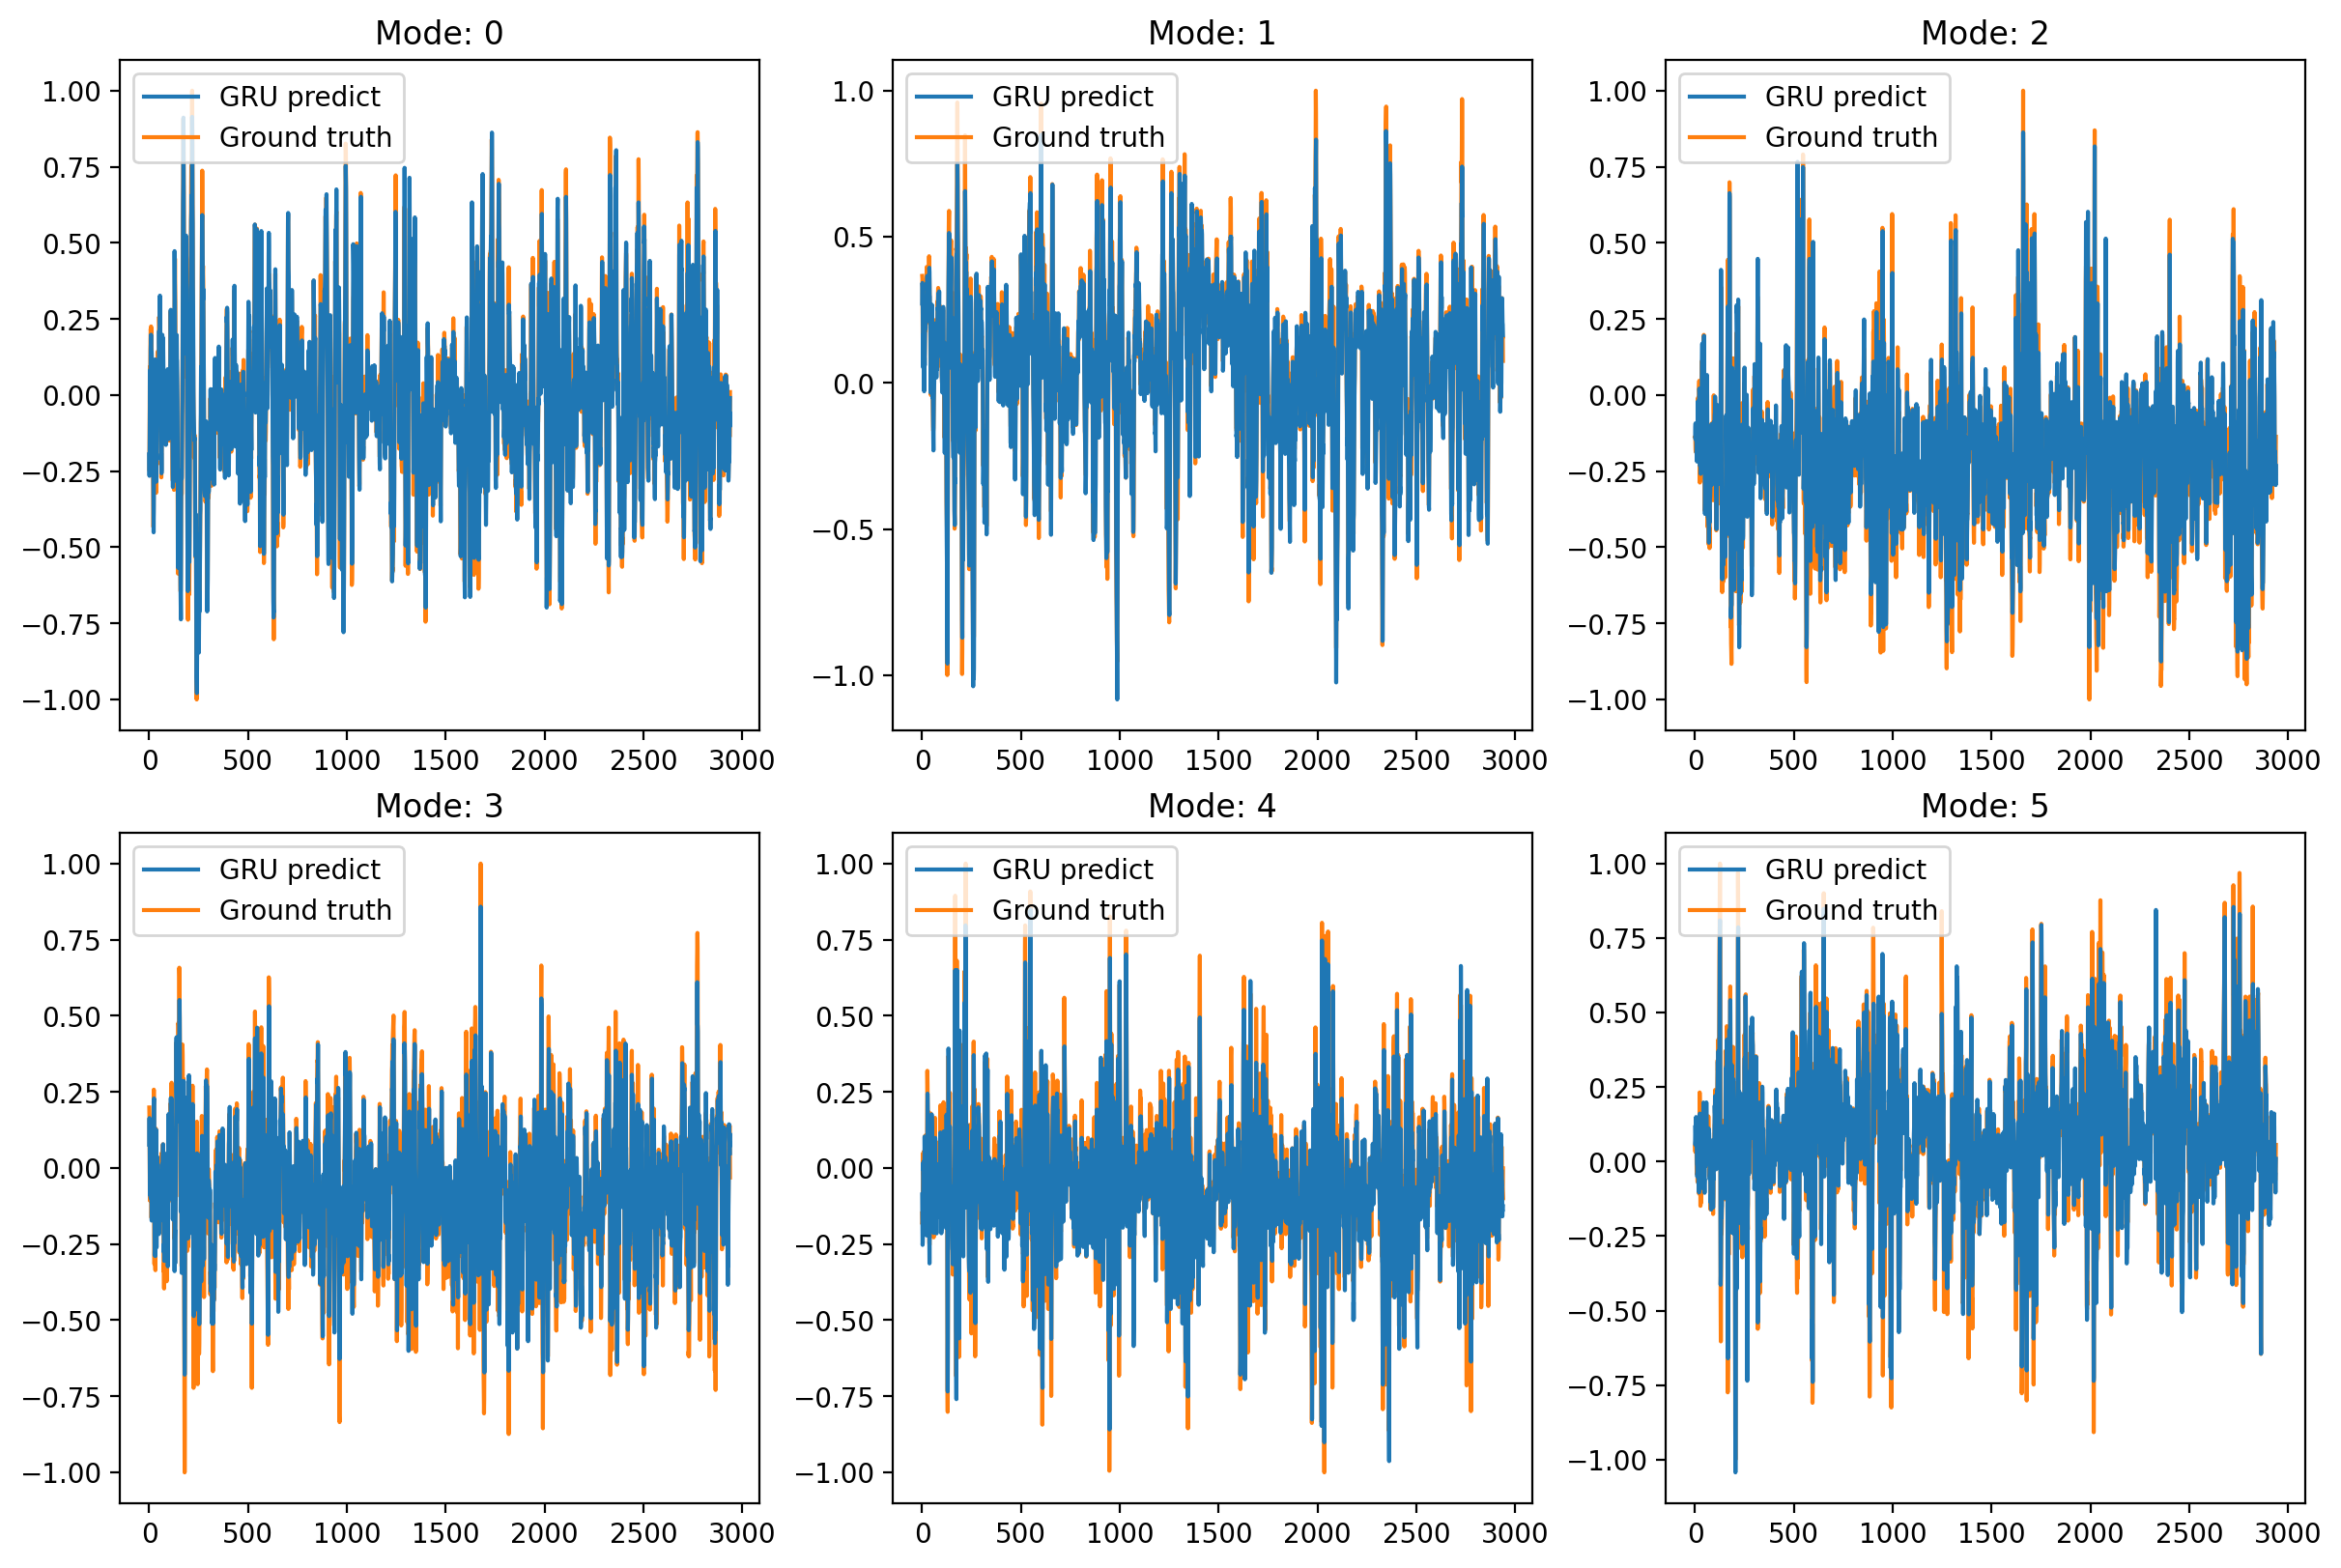

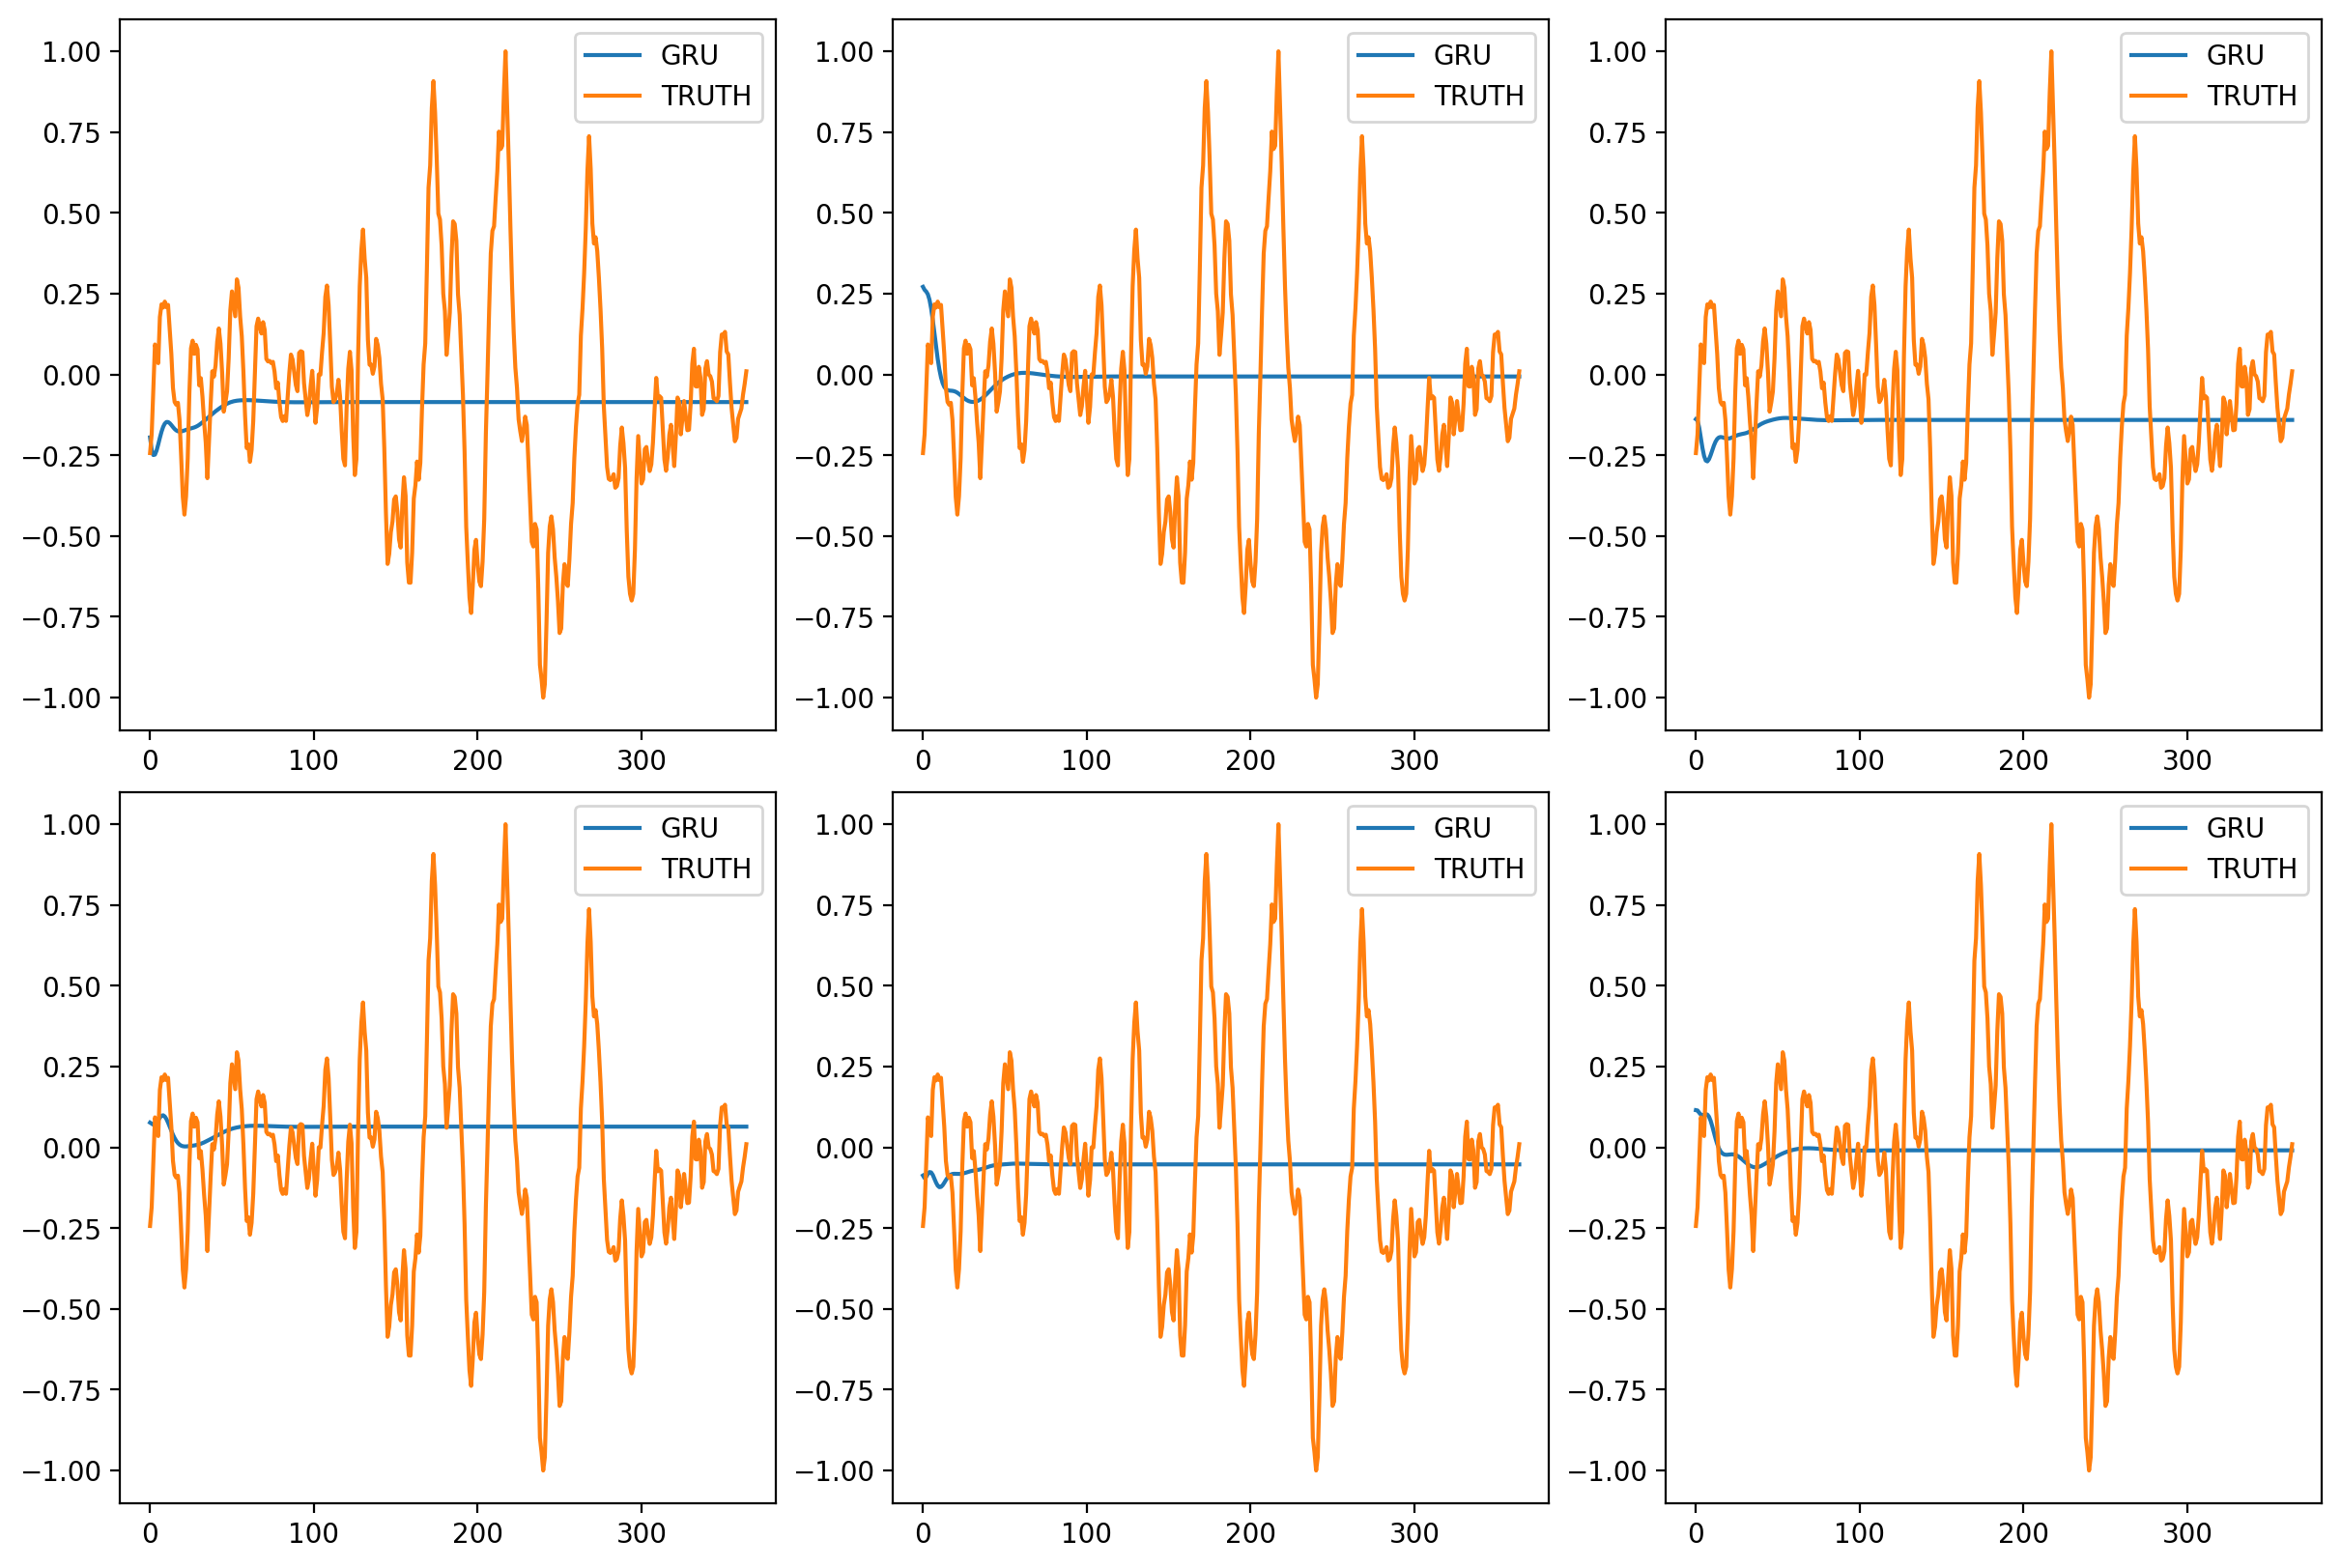

In [23]:
os.chdir(config["Path_img"])
fig, axes = plt.subplots(nrows = 2,
                         ncols = 3, 
                         figsize = (12, 8), 
                         dpi = 200,
                         constrained_layout = True)
for i, ax in enumerate(axes.flat):
    ax.plot(GRU_predict[:time_window,i], label = "GRU predict", zorder = 3)
    ax.plot(GRU_truth[:time_window,i], label = "Ground truth")
    ax.set_title(f"Mode: {i}")
    ax.legend(loc = 2)
plt.savefig("GRU_Iter.png")
plt.show()

fig, axes = plt.subplots(nrows = 2,
                         ncols = 3, 
                         figsize = (12, 8), 
                         dpi = 200,
                         constrained_layout = True)
for i, ax in enumerate(axes.flat):
    ax.plot(GRU_forecast[:,i], label = "GRU")
    ax.plot(test_set[config["ML_hyperparam_lookback"]:config["ML_hyperparam_lookback"]+config["ML_hyperparam_forecast_step"],0], label = "TRUTH")
    ax.legend()
plt.savefig("GRU_Gen.png")
plt.show()

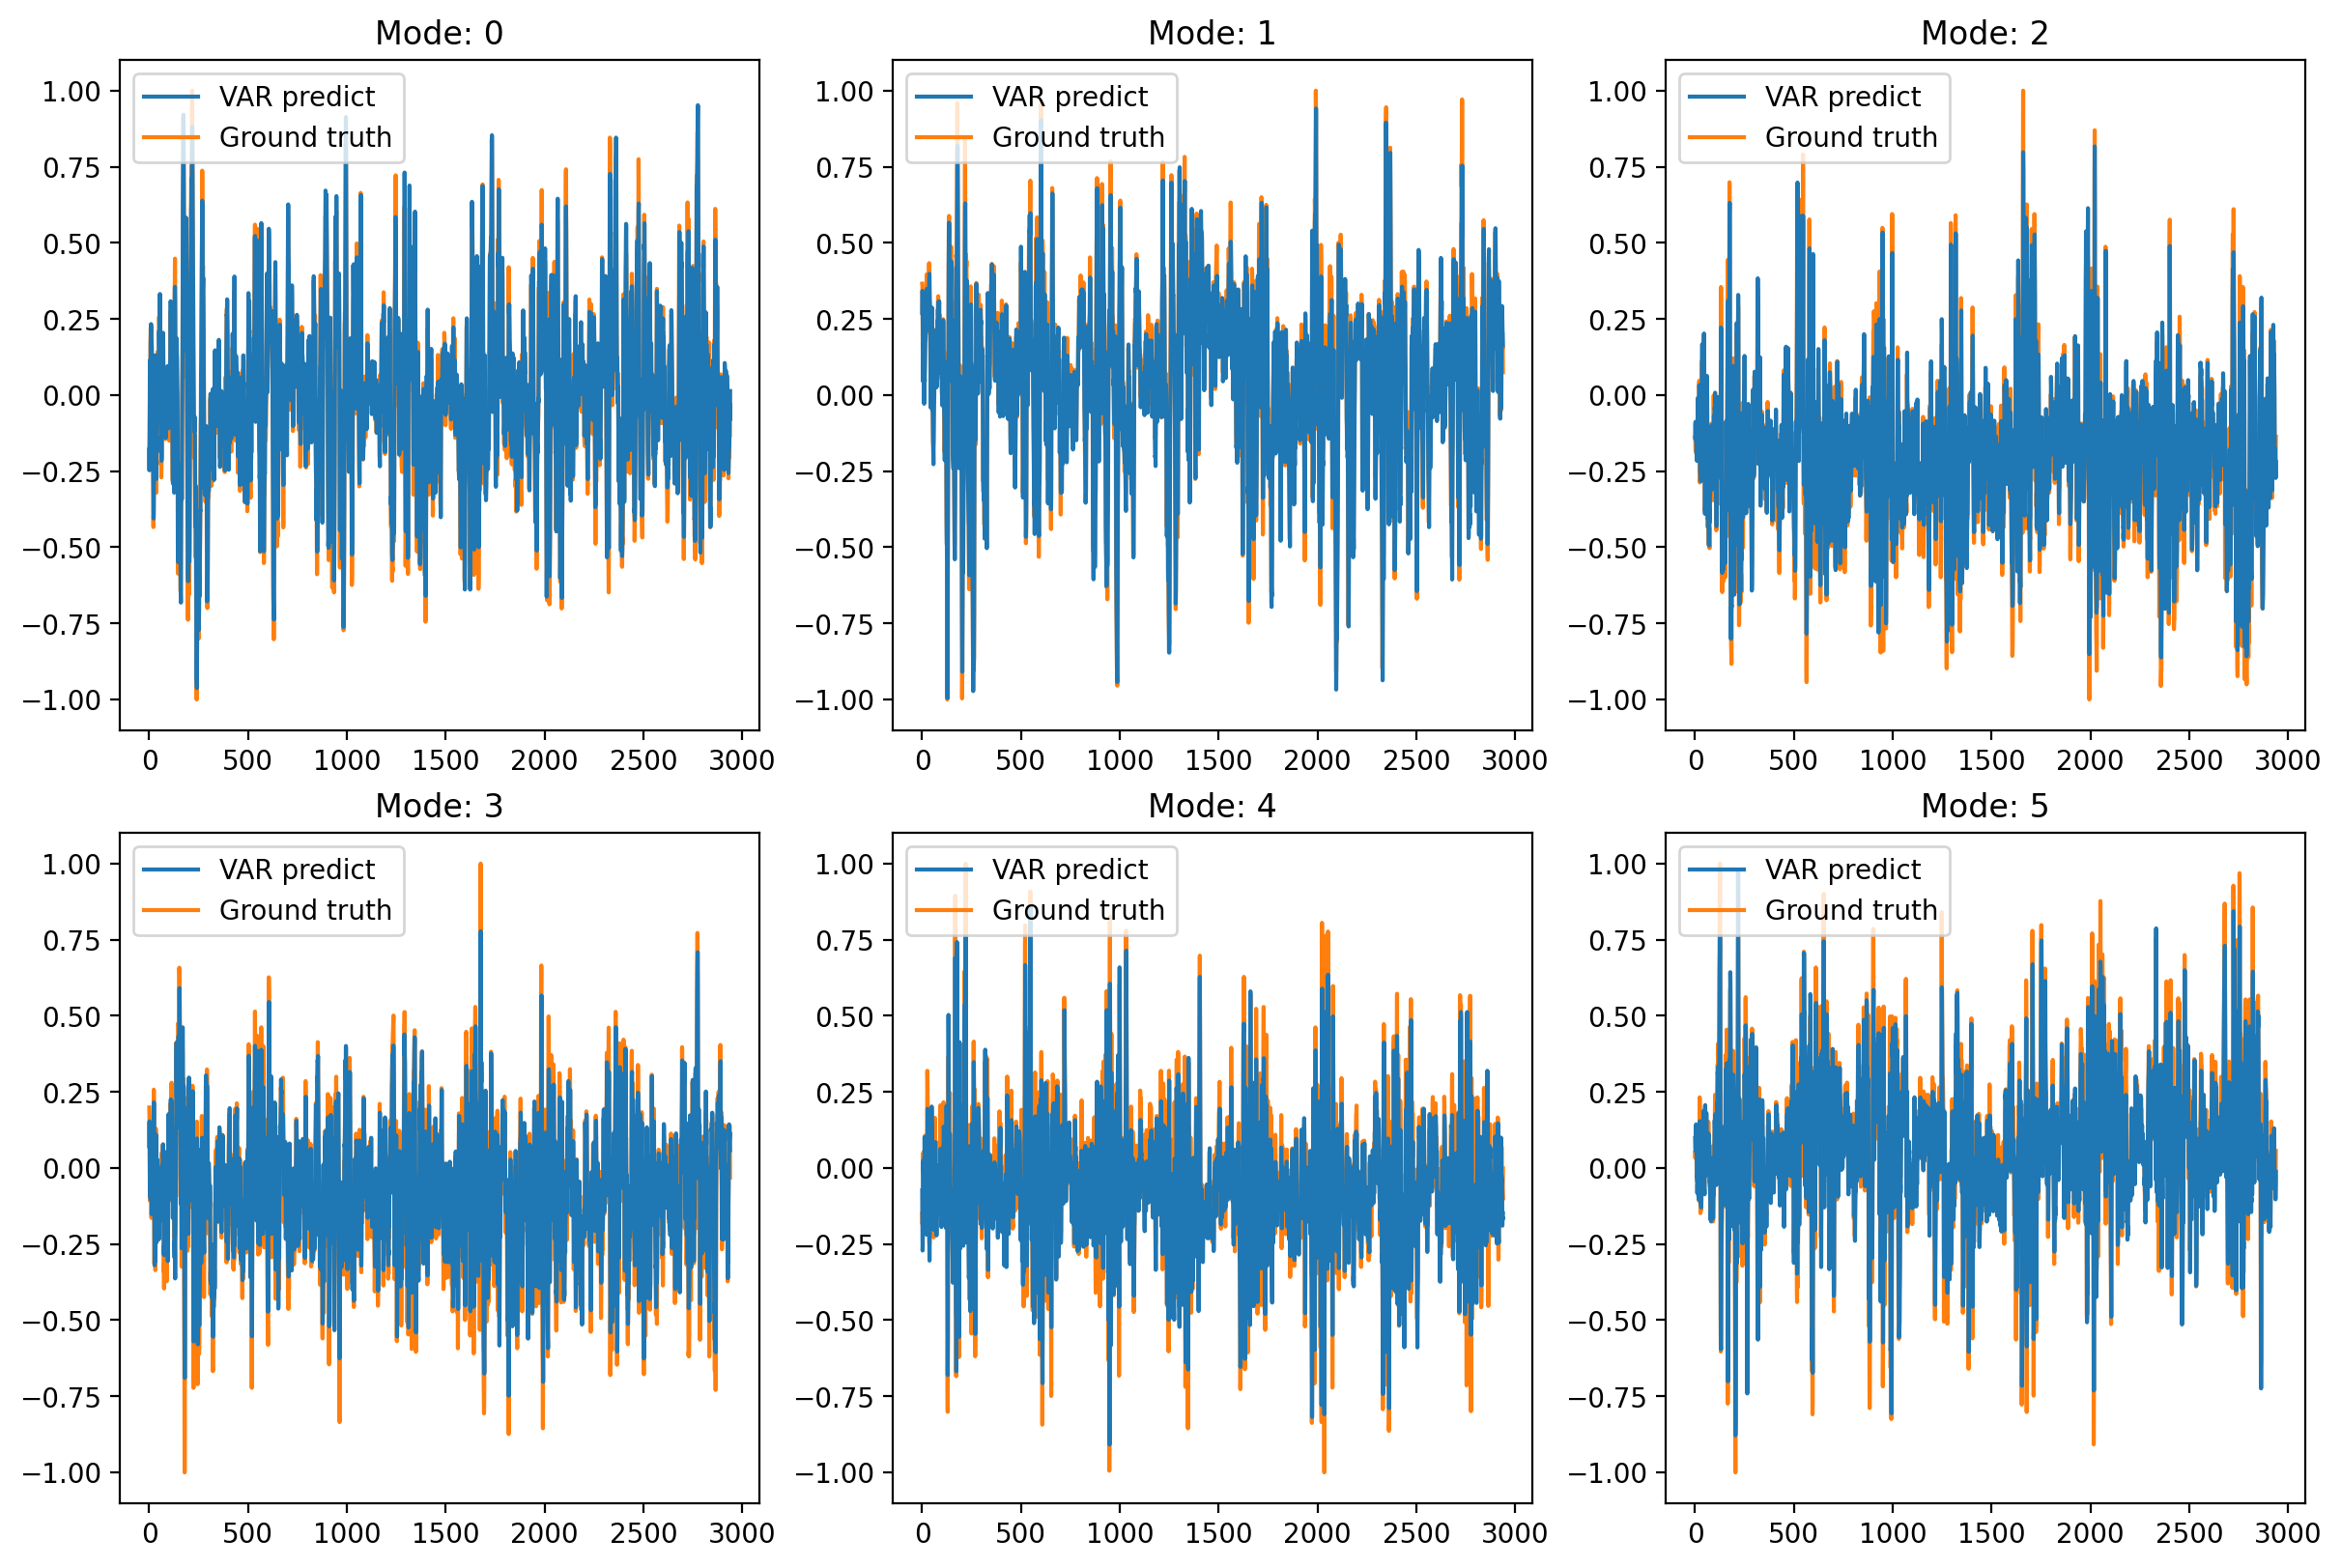

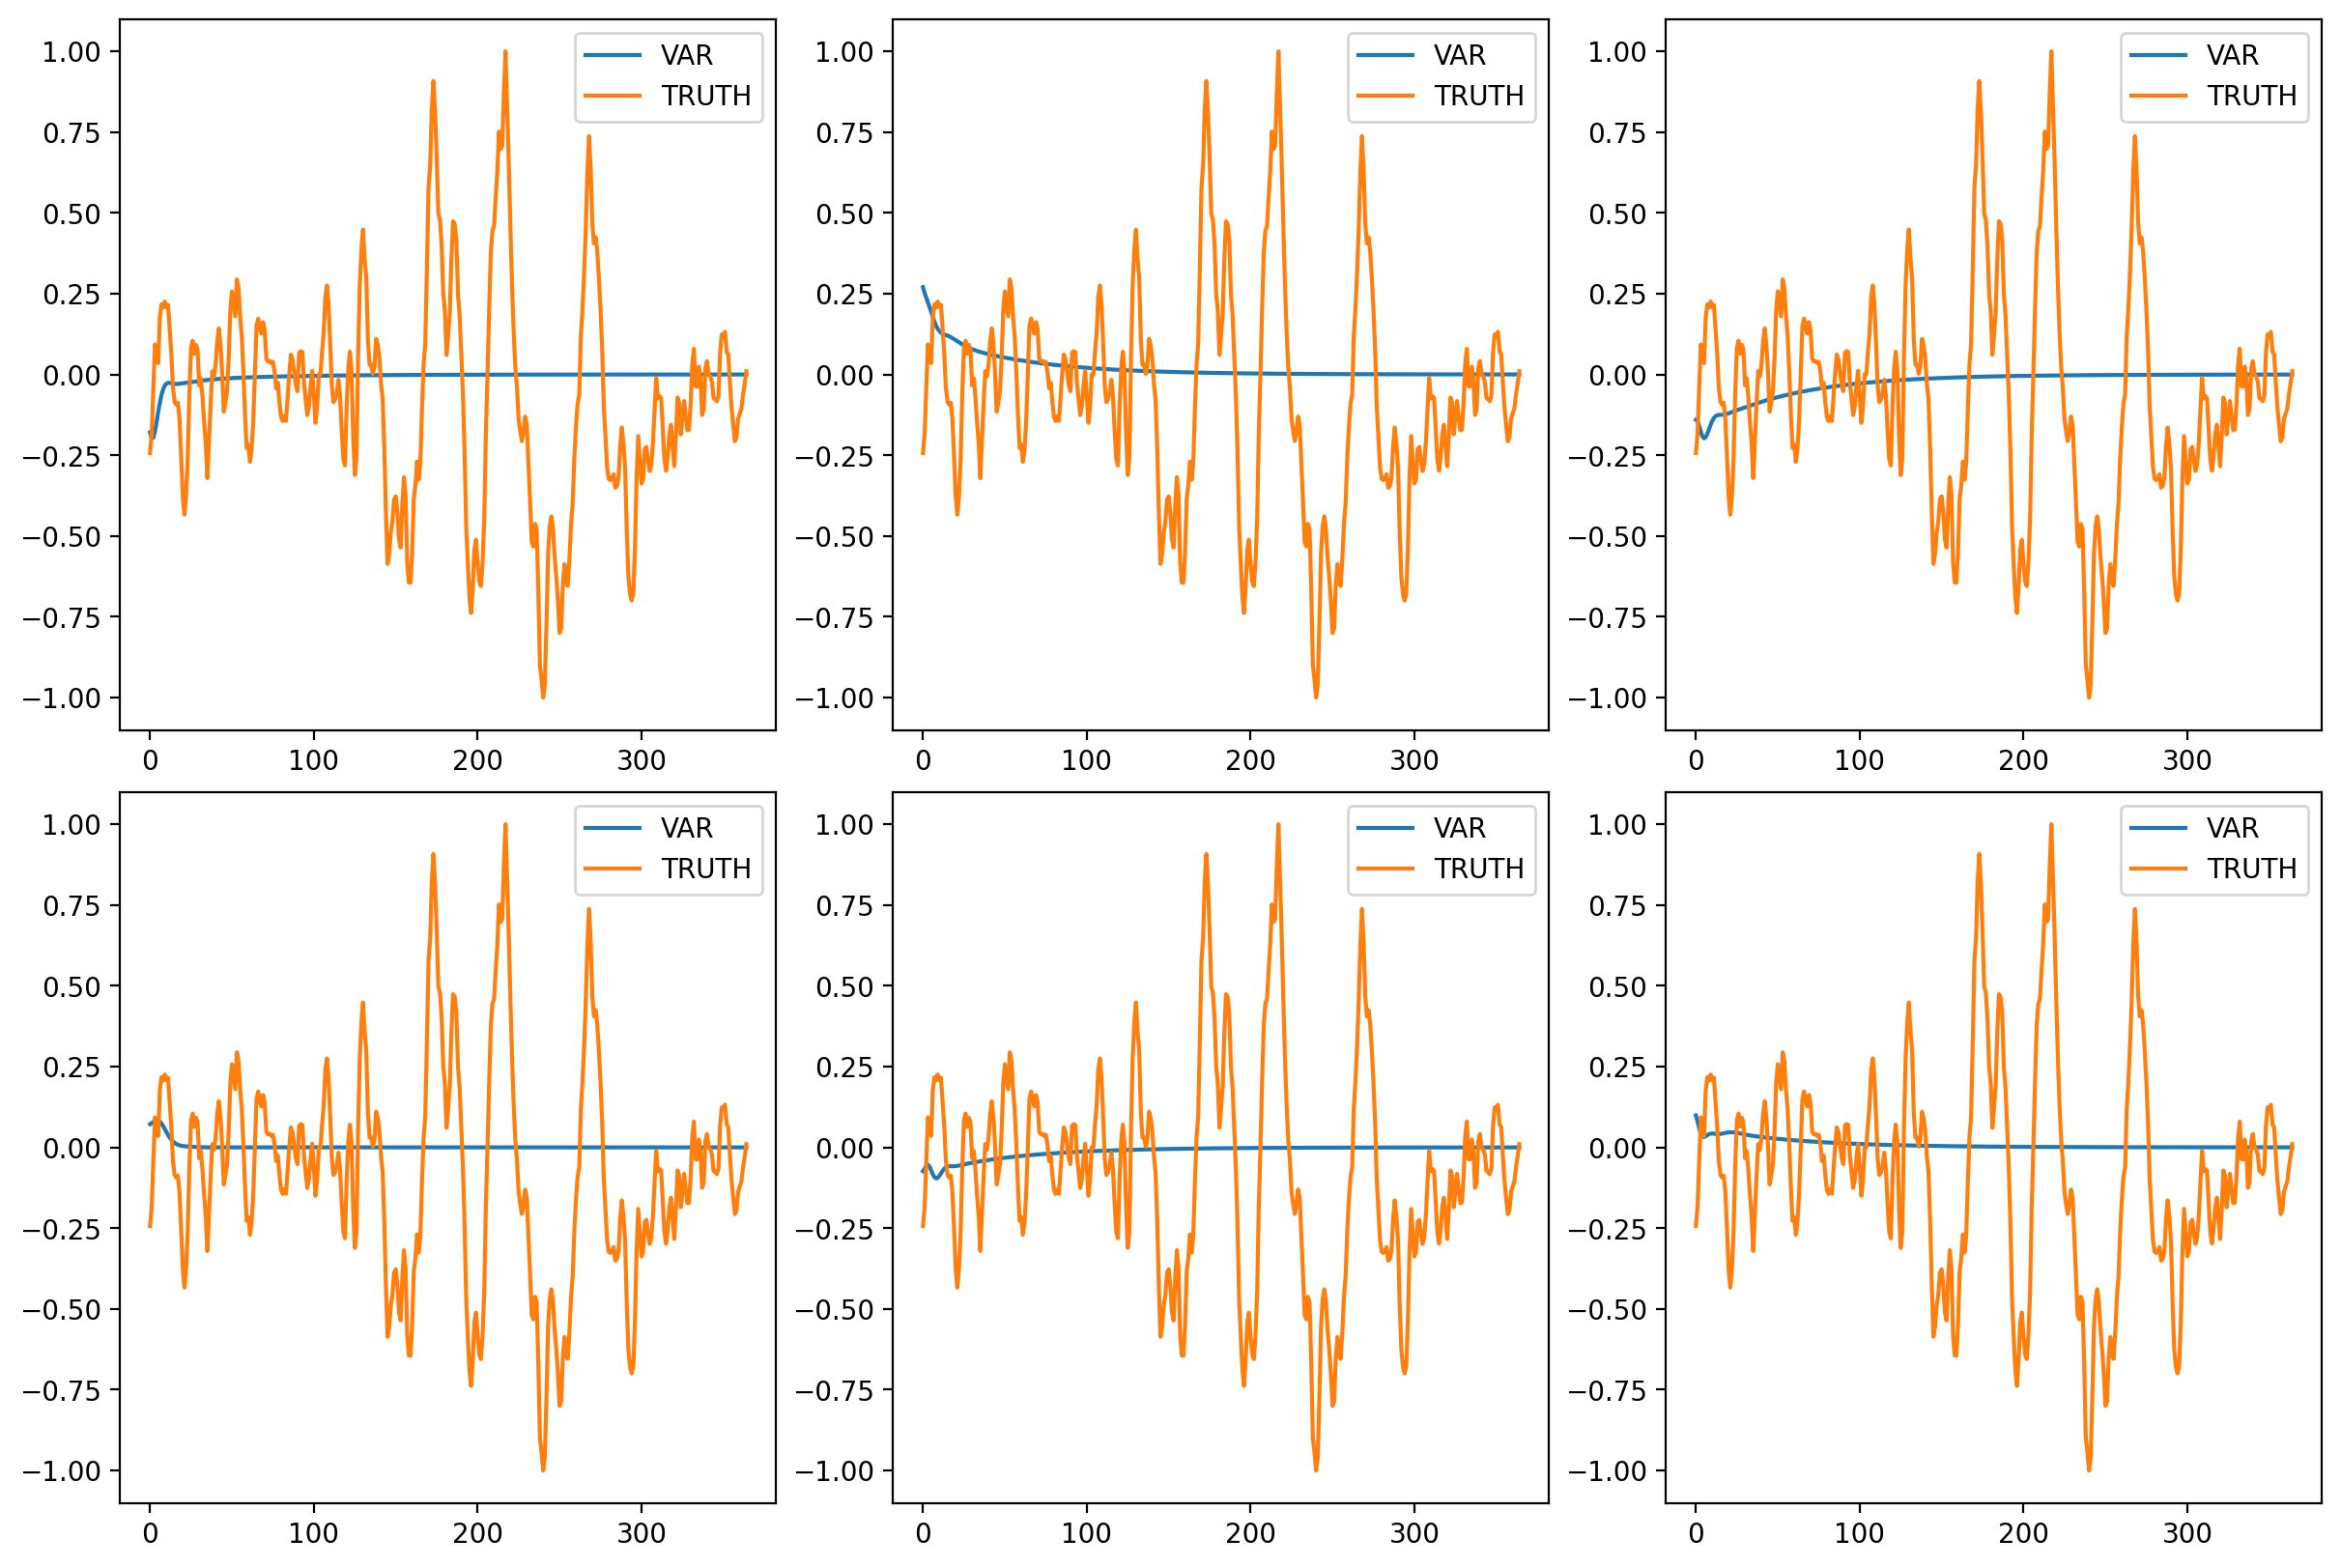

In [24]:
os.chdir(config["Path_img"])
fig, axes = plt.subplots(nrows = 2,
                         ncols = 3, 
                         figsize = (12, 8), 
                         dpi = 200,
                         constrained_layout = True)
for i, ax in enumerate(axes.flat):
    ax.plot(VAR_predict[:time_window,i], label = "VAR predict", zorder = 3)
    ax.plot(VAR_truth[:time_window,i], label = "Ground truth")
    ax.set_title(f"Mode: {i}")
    ax.legend(loc = 2)
plt.savefig("VAR_Iter.png")
plt.show()

fig, axes = plt.subplots(nrows = 2,
                         ncols = 3, 
                         figsize = (12, 8), 
                         dpi = 200,
                         constrained_layout = True)
for i, ax in enumerate(axes.flat):
    ax.plot(VAR_forecast[:,i], label = "VAR")
    ax.plot(test_set[config["ML_hyperparam_lookback"]:config["ML_hyperparam_lookback"]+config["ML_hyperparam_forecast_step"],0], label = "TRUTH")
    ax.legend()
plt.savefig("VAR_Gen.png")
plt.show()

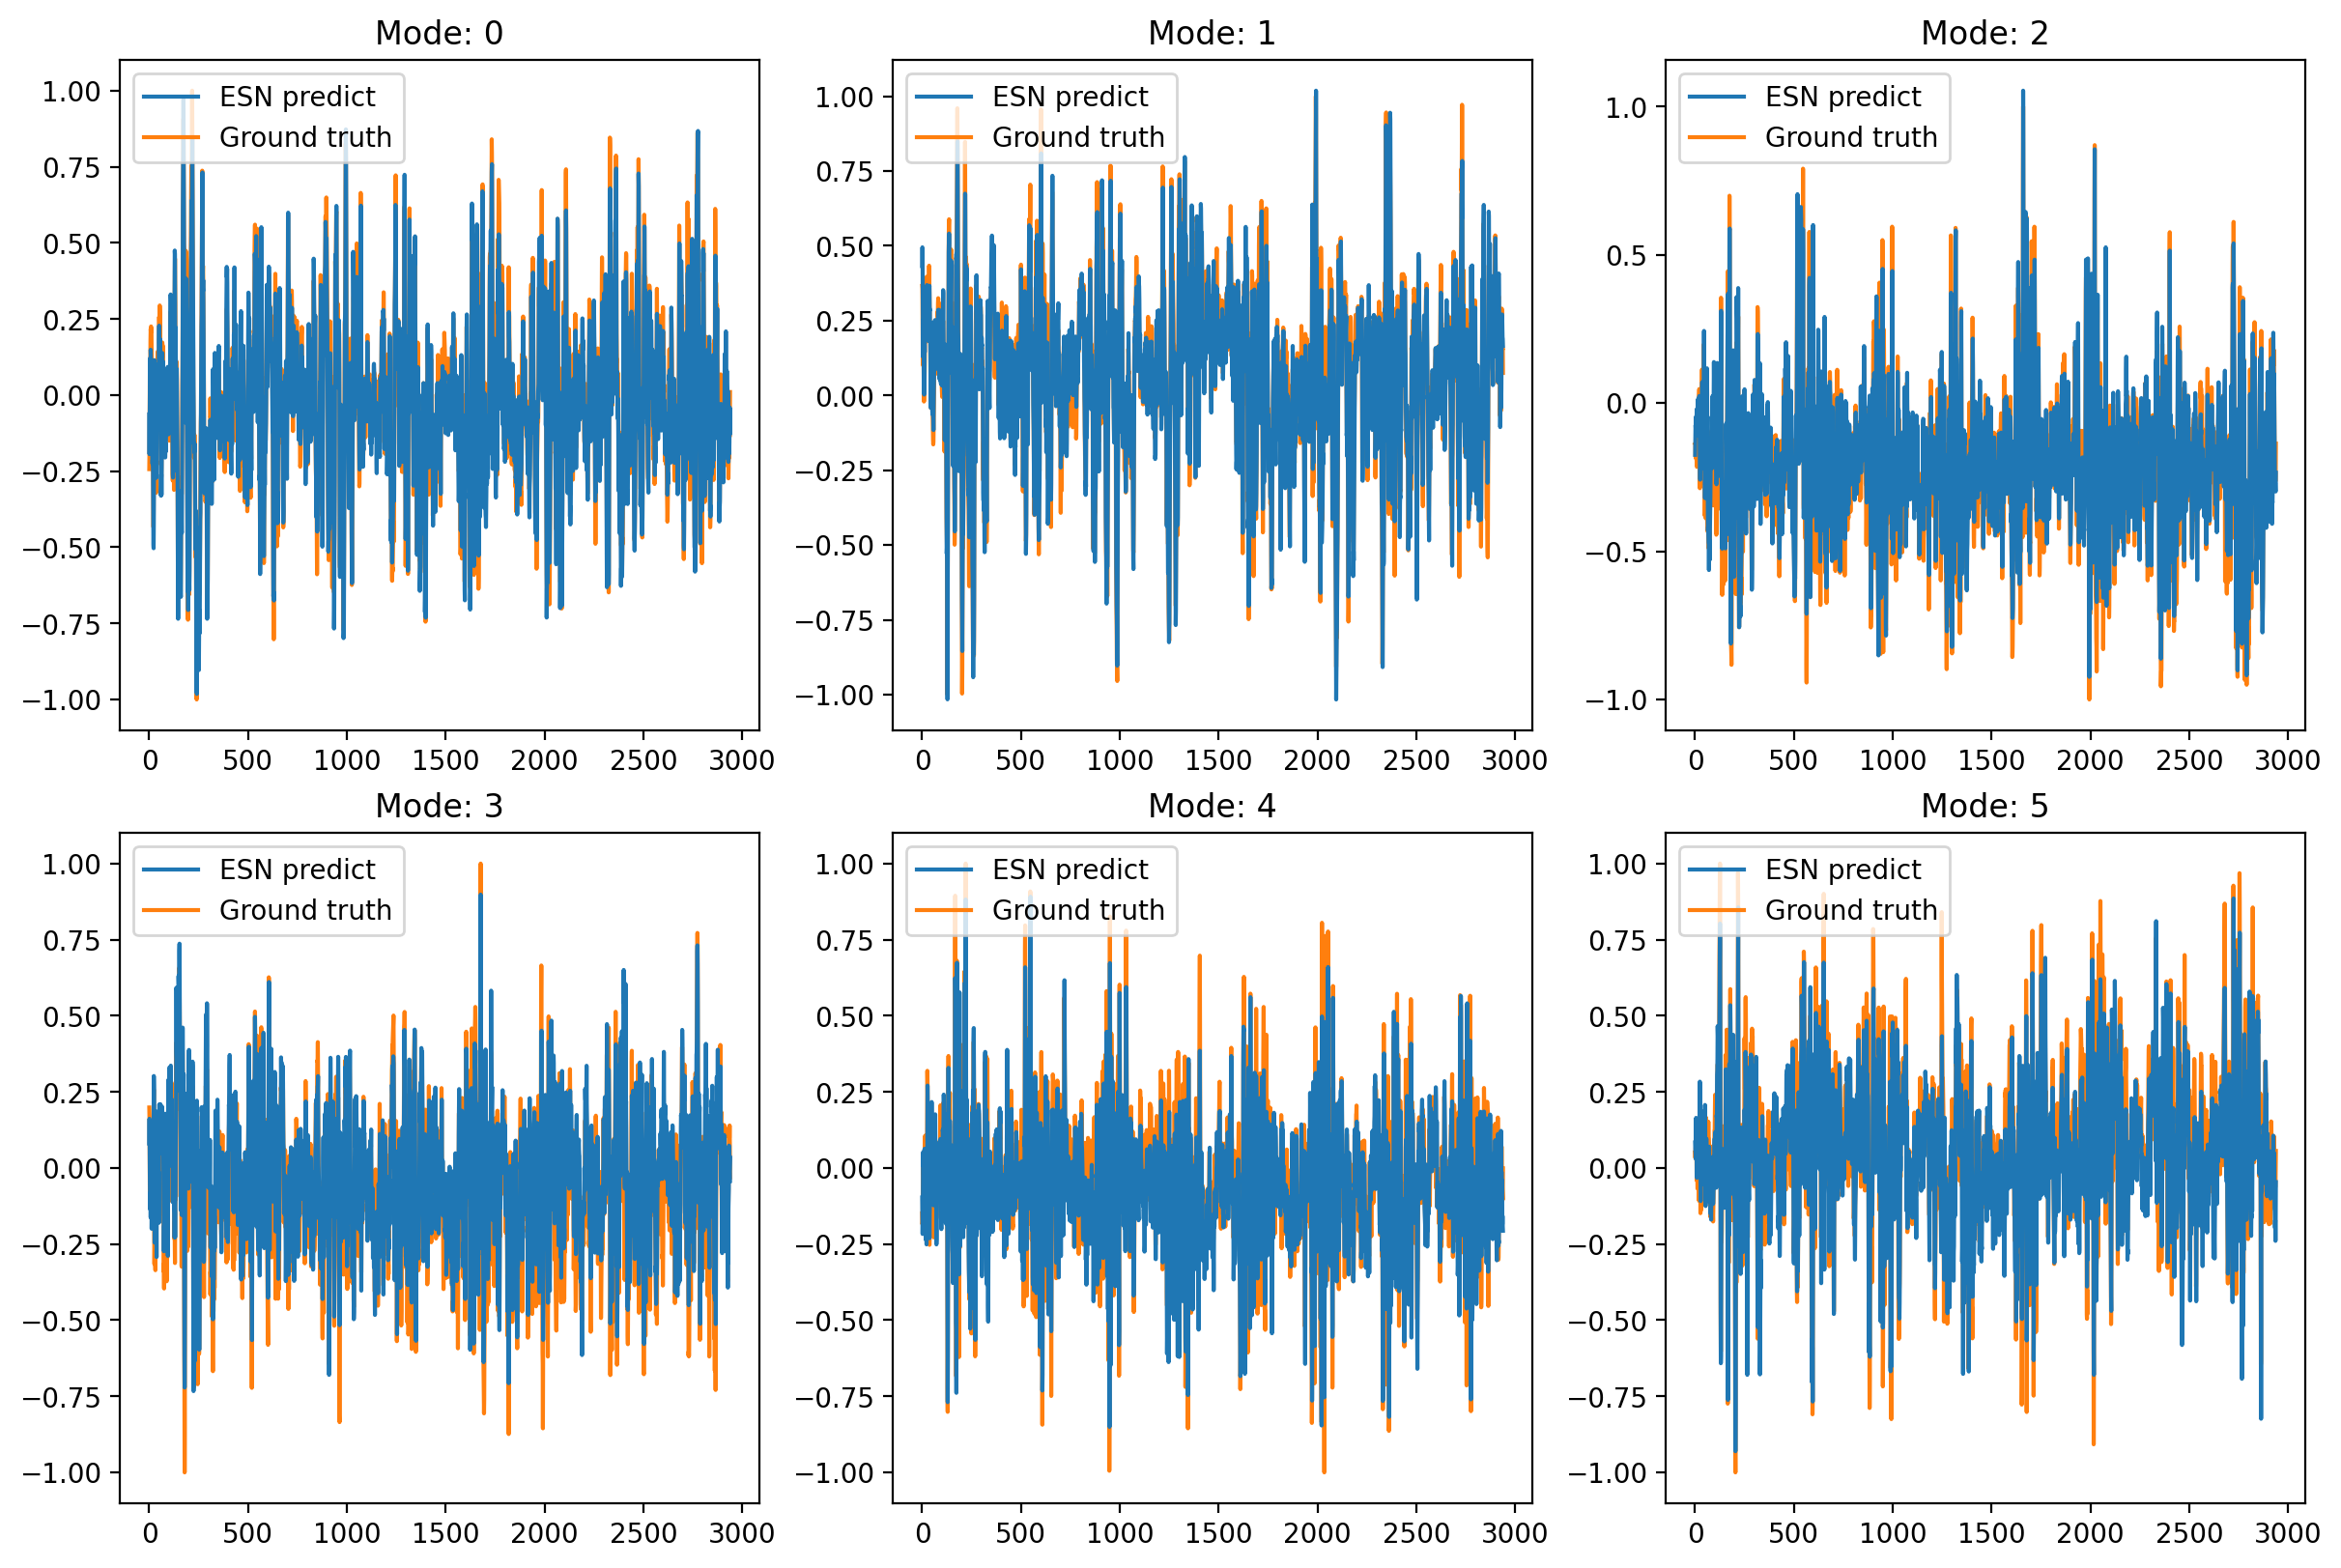

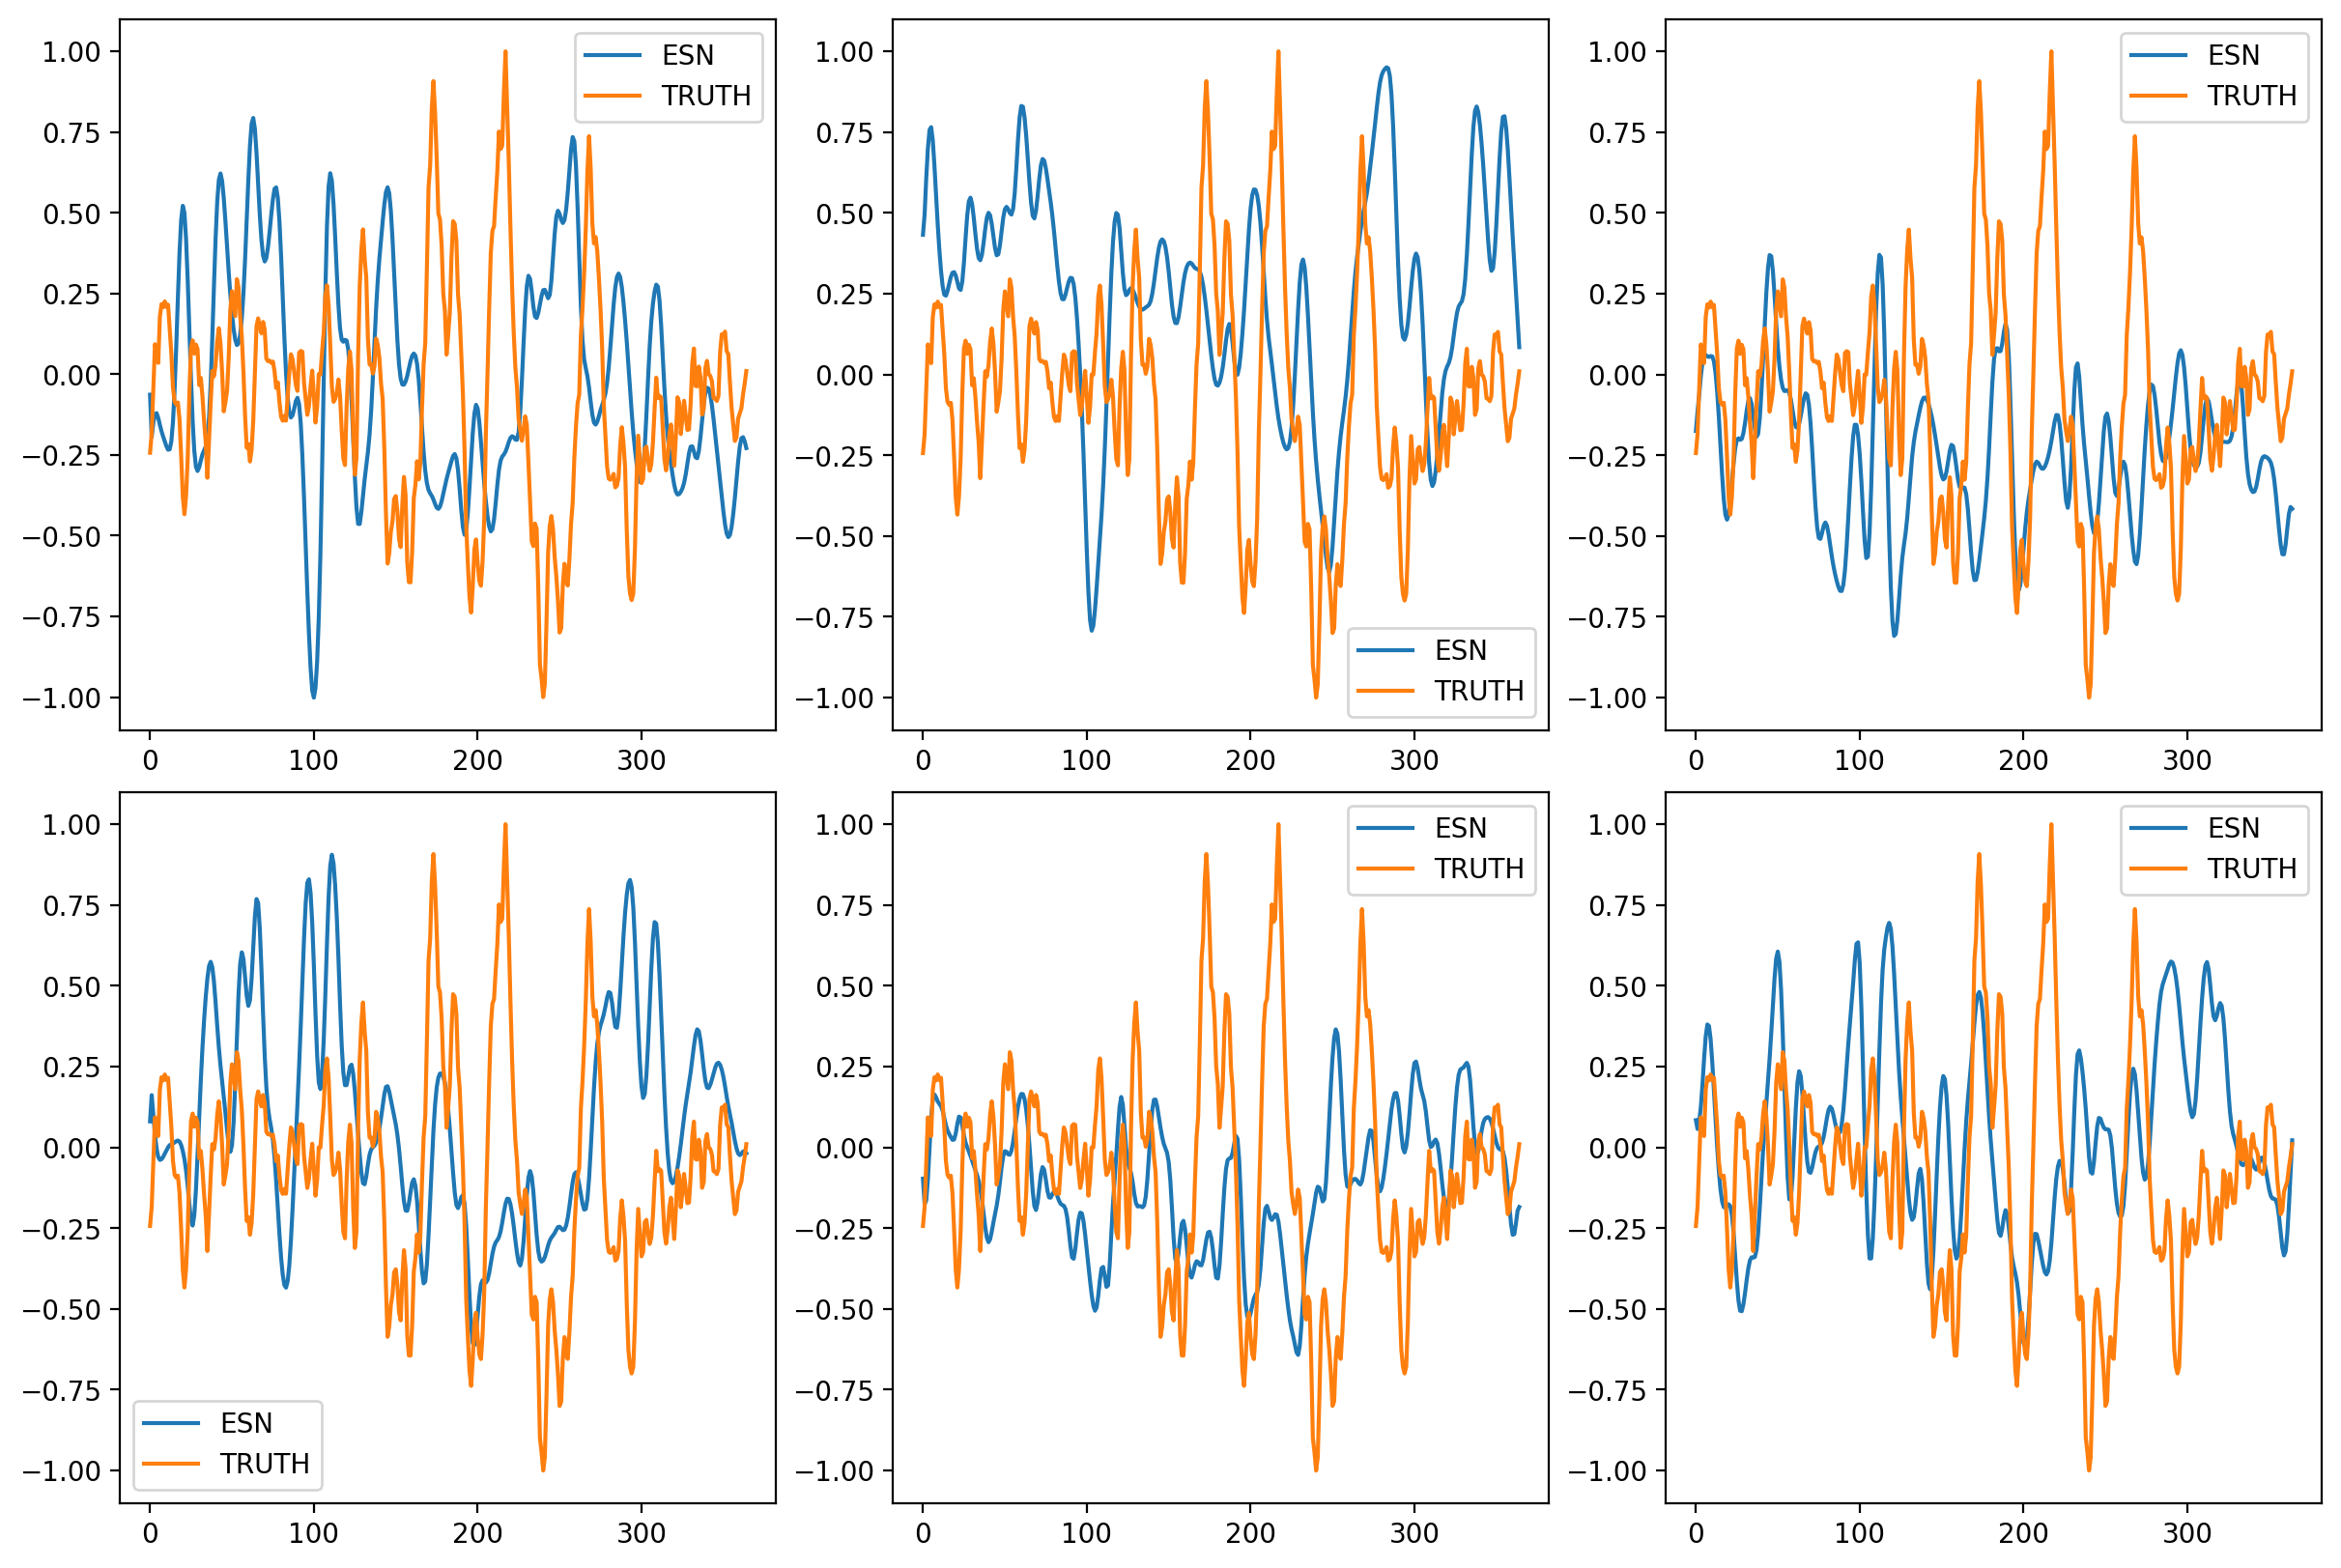

In [25]:
os.chdir(config["Path_img"])
fig, axes = plt.subplots(nrows = 2,
                         ncols = 3, 
                         figsize = (12, 8), 
                         dpi = 200,
                         constrained_layout = True)
for i, ax in enumerate(axes.flat):
    ax.plot(ESN_predict[:time_window,i], label = "ESN predict", zorder = 3)
    ax.plot(ESN_truth[:time_window,i], label = "Ground truth")
    ax.set_title(f"Mode: {i}")
    ax.legend(loc = 2)
plt.savefig("ESN_Iter.png")    
plt.show()

fig, axes = plt.subplots(nrows = 2,
                         ncols = 3, 
                         figsize = (12, 8), 
                         dpi = 200,
                         constrained_layout = True)
for i, ax in enumerate(axes.flat):
    ax.plot(ESN_forecast[:,i], label = "ESN")
    ax.plot(test_set[config["ML_hyperparam_lookback"]:config["ML_hyperparam_lookback"]+config["ML_hyperparam_forecast_step"],0], label = "TRUTH")
    ax.legend()
plt.savefig("ESN_Gen.png")
plt.show()